In [1]:
%matplotlib inline
# All required dependencies for all plots 
import aplpy
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from NOEMAsetup import *
from spectral_cube import SpectralCube
from ChauvenetRMS import *
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import AsinhStretch
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse, Rectangle


In [2]:
def plot_aplpy_standard(image, stretch, vmin, vmax, cmap, phasecent=[ra_Per50, dec_Per50], radiusplot= 16/3600, vmid=0.01, figsize=(4,4), label_col='w', star_col='r'):
    fig = aplpy.FITSFigure(image, figsize=figsize)
    if stretch=='arcsinh':
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
    else:
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.add_colorbar()
    setup_plot_noema(fig, label_col=label_col, star_col=star_col)
    fig.beam.set_color('k')
    fig.beam.set_frame(True)
    fig.scalebar.set_linewidth(2)
    return fig

## H2CO Plots

### Moment 0

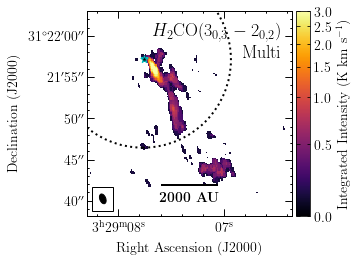

In [23]:
saveaction = 0
contourplot = 0
# regionplot = 0

folder = 'H2CO/CDconfigsmall/'
filename = H2CO_303_202_s + '_fitcube_total_mom0'
cleanalg = 'Multi'
stretch = 'arcsinh'

# moment = 0
# velinit = 7 #km/s
# velend = 8 #km/s

# savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'_SMAbeam.pdf'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom0' + '_'+stretch + '.pdf'
vmin = 0
vmax = 3.
vmid = 0.5
cmap = 'inferno'
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)'

# contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
# contourfile2 = filename+'.fits'
# contlevels = [0.007]
# regions = folder +'spectra_regs.reg'

# cube = SpectralCube.read(filename+'.fits')
# cube = cube.with_spectral_unit(u.km/u.s)
# headercube = cube.hdu.header
headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

# subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
# moment0 = subcube.moment(order=moment).hdu
# rms = calculatenoise(moment0.data)[0]
if contourplot:
    contour2 = filename + '.fits'
#     contourfile = SpectralCube.read(contourfile)
#     contourfile = contourfile[0,:,:]
#     contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
#     contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
#     rms2 = calculatenoise(contour2.data)[0]
    
# fig = plot_aplpy_standard(moment0, stretch, vmin, vmax, cmap)
fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
# fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
# if regionplot:
#     fig.show_regions(regions)
fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Moment 1

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cm.set_bad(color)


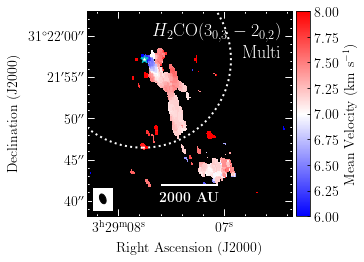

In [28]:
saveaction = 1
filename = H2CO_303_202_s + '_fitcube_total_mom1'
stretch = 'linear'
cmap = 'bwr'
nancolor = 'k'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom1' + '_'+stretch + '.pdf'
vmin = 6
vmax = 8

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='c')
# fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Mean Velocity (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)

fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Moment 2

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


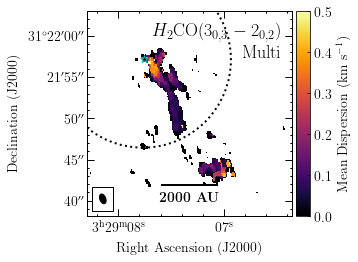

In [43]:
saveaction = 0
filename = H2CO_303_202_s + '_fitcube_total_sigma'
stretch = 'linear'
cmap = 'inferno'
nancolor = 'w'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_sigma' + '_'+stretch + '.pdf'
vmin = 0
vmax = 0.5

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'Mean Dispersion (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)

fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Moment 8

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


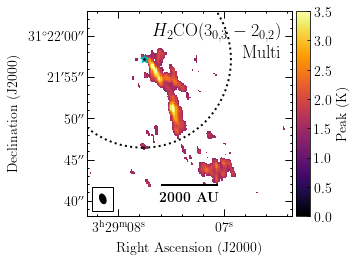

In [48]:
saveaction = 1
filename = H2CO_303_202_s + '_fitcube_total_mom8'
stretch = 'linear'
cmap = 'inferno'
nancolor = 'w'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom8' + '_'+stretch + '.pdf'
vmin = 0
vmax = 3.5

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'Peak (K)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)

fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

## Noise plots


### H2CO

In [ ]:
saveaction = 0
contourplot = 0
regionplot = 0

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi, C+D config'
stretch = 'arcsinh'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'.pdf'
vmin = -0.01
vmax = 0.03
vmid = 0.001
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'spectra_regs.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment = subcube.moment(order=moment).hdu
rms = calculatenoise(moment0.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = plot_aplpy_standard(moment, stretch, vmin, vmax, cmap, vmid=vmid)
fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
if regionplot:
    fig.show_regions(regions)
fig.add_label(0.95,0.85, title, color='white',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


## Gaussian Fit result plots

H2CO fit results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-

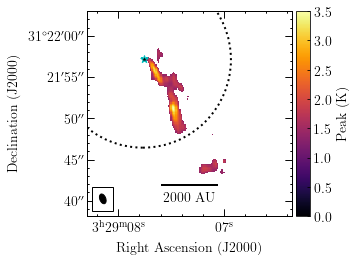

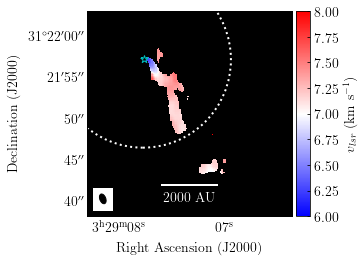

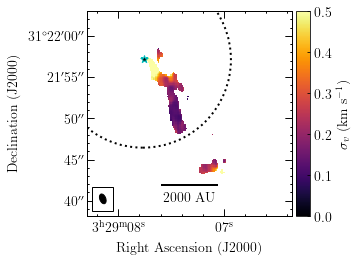

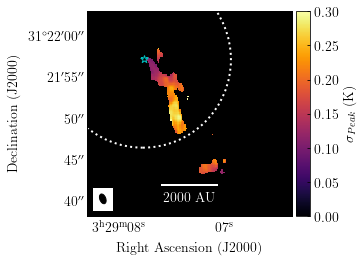

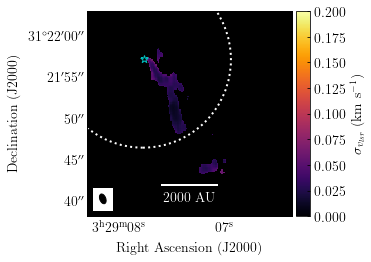

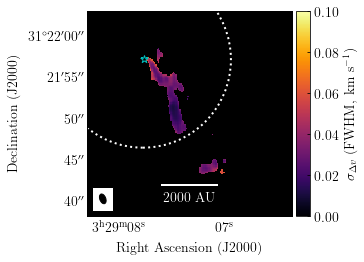

In [46]:
saveaction = 0

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2, 3, 4, 5] # 0 is amplitude, 1 is mean velocity, 2 is dispersion
vmin = [0 , 6, 0, 0, 0, 0]
vmax = [3.5, 8, 0.5, 0.3, 0.2, 0.1]
parameter_names = [r'Peak (K)', r'$v_{lsr}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)', r'$\sigma_{Peak}$ (K)', r'$\sigma_{v_{lsr}}$ (km s$^{-1}$)', r'$\sigma_{\Delta v}$ (FWHM, km s$^{-1}$)']
cmaps = ['inferno', 'bwr', 'inferno', 'inferno', 'inferno', 'inferno']
nancolor = ['w', 'k', 'w', 'k', 'k', 'k']
for i in parameters:
  moment = paramcube[i]
#   if i == 2 or i==5:
#     moment *= np.sqrt(8*np.log(2)) # convert sigma to FWHM
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin[i], vmax[i], cmaps[i], label_col='k', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  if nancolor[i] == 'k':
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
    fig.scalebar.set_color('w')
  else:
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
  fig.set_nan_color(nancolor[i])
  if saveaction:
    savefile = filename + 'parameter'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)




For comparison, we plot the moment map (does not work right now)

In [ ]:
saveaction = 0

folder = 'H2CO/CDconfigsmall/'
filename = H2CO_303_202_s + '_fitcube'
cleanalg = 'Multi'
stretch = 'linear'
moment = 1
velinit = 5.5 #km/s
velend = 9.5 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'.pdf'
vmin = 6.5
vmax = 8
vmid = 0.01
cmap = 'bwr'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
wcsspec = WCS(headercube).spectral

# rough rms to mask
rms = np.sqrt(np.mean((np.vstack([cube[:int(wcsspec.all_world2pix(velinit*1e3, 0)[0]), :, :], cube[int(wcsspec.all_world2pix(velend*1e3,0)[0]):,:,:]]))**2))
mask = cube > 4*rms*u.Jy/u.beam
cube = cube.with_mask(mask)
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)

moment0 = subcube.moment(order=moment).hdu
rms = calculatenoise(moment0.data)[0]


fig = plot_aplpy_standard(moment0, stretch, vmin, vmax, cmap, label_col='k', star_col='c')
# fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Central Velocity Moment (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)

# fig.add_label(0.95,0.85, title, color='white',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color('k')
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)